In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
from scipy.stats import t

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Matplotlib is building the font cache; this may take a moment.


In [38]:
fpath_idx = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data'

fpath_nc = {'CM4': '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp',
            'ESM4':'/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/pp'}

fpath_stormmmask = {'CM4': '/work/Katherine.Turner/tempest-extremes/odiv-251/comp_wind/v_ref_masked*.nc',
                    'ESM4': '/work/Katherine.Turner/tempest-extremes/ESM4/wind/masked*.nc'}

files = {'CM4': {'tos': 'ocean_daily_1x1deg/ts/daily/5yr/*.tos.nc',
                 'slp': 'atmos/ts/monthly/5yr/*.slp.nc',
                 'u_ref': 'atmos/ts/monthly/5yr/*.u_ref.nc'},
         'ESM4': {'tos': 'ocean_monthly/ts/monthly/5yr/*.tos.nc',
                  'slp': 'atmos/ts/monthly/5yr/*.slp.nc',
                  'u_ref': 'atmos/ts/monthly/5yr/*.u_ref.nc'},
        }

c = {'slp': 1,
     'tos': 1,
     'u_ref': 1}

mod='ESM4'
var='tos'

## High and low years using whatever index (storm centers, SAM, etc)

In [39]:
ds_idx = xr.open_dataset(f'{fpath_idx}/{mod}_monthly_storms.nc')

idx = ds_idx.center_counts.resample(time='QS-DEC').sum()[4:-4:4] # for djf data
#idx = ds_idx.center_counts.resample(time='QS-DEC').sum()[2::4] # for jja data

#idx2 = ds_idx.center_counts[3:-3].coarsen(time=6).sum()[1:-2:2]
#idx2 = ds_idx.center_counts[3:-3].coarsen(time=6).sum()[0:-2:2]

low_years = idx.sortby(idx).time[:7].dt.year
high_years = idx.sortby(idx).time[-7:].dt.year

#low_years2 = idx2.sortby(idx2).time[:7].dt.year
#high_years2 = idx2.sortby(idx2).time[-7:].dt.year

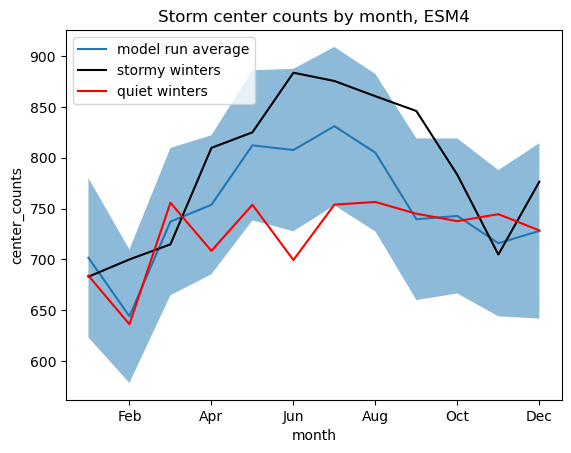

In [129]:
mu = ds_idx.center_counts.groupby(ds_idx.time.dt.month).mean()
std = ds_idx.center_counts.groupby(ds_idx.time.dt.month).std()

#idx_hi = (ds_idx.time.dt.year.isin(high_years2) & ds_idx.time.dt.month.isin([7,8,9,10,11,12])) | (ds_idx.time.dt.year.isin(high_years2 + 1) & ds_idx.time.dt.month.isin([1,2,3,4,5,6]))
#idx_low = (ds_idx.time.dt.year.isin(low_years2) & ds_idx.time.dt.month.isin([7,8,9,10,11,12])) | (ds_idx.time.dt.year.isin(low_years2 + 1) & ds_idx.time.dt.month.isin([1,2,3,4,5,6]))

#idx_hi = ds_idx.time.dt.year.isin(high_years2)
#idx_low = ds_idx.time.dt.year.isin(low_years2)

mu_hi = ds_idx.center_counts[idx_hi].groupby(ds_idx.time[idx_hi].dt.month).mean()
mu_low = ds_idx.center_counts[idx_low].groupby(ds_idx.time[idx_low].dt.month).mean()

fig, axs = plt.subplots()
mu.plot(label='model run average')
axs.fill_between(range(1,13), (mu - std), (mu + std), alpha= 0.5)

mu_hi.plot(color='k', label='stormy winters')
mu_low.plot(color='r', label='quiet winters')

plt.legend()
plt.title(f'Storm center counts by month, {mod}')

axs.set_xticks(np.arange(2,13,2))
axs.set_xticklabels(['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])

plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_centers_6mowinter_{mod}.png', 
            format='png', 
            dpi=100)

In [18]:
ds_mask = xr.open_mfdataset(fpath_stormmmask[mod],use_cftime=True)

mask_monthly = 0.25 * ds_mask.mask.resample(time='M').sum()
mask_monthly = mask_monthly.compute()
mask_monthly.to_dataset(name='mask_monthly').to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc')

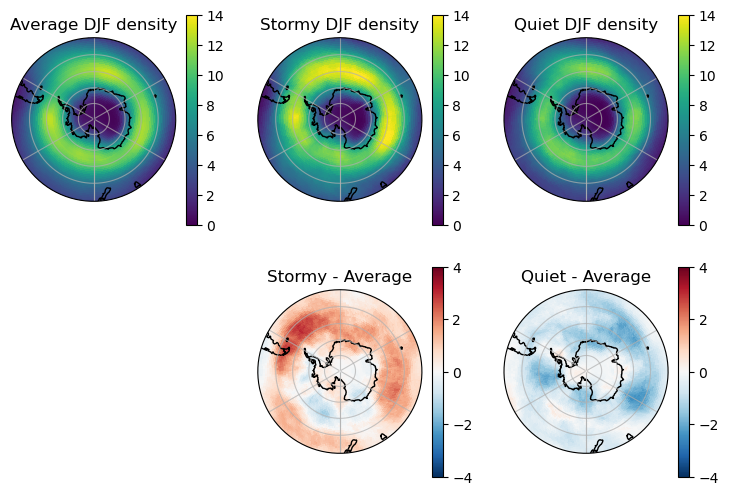

In [40]:
ds_mask = xr.open_mfdataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc',use_cftime=True)
mask_monthly = ds_mask.mask_monthly

#for summers where we have to skip over the years
idx_djf = mask_monthly.time.dt.month.isin([12,1,2])
idx_hi = (mask_monthly.time.dt.year.isin(high_years) & mask_monthly.time.dt.month.isin([12])) | (mask_monthly.time.dt.year.isin(high_years + 1) & mask_monthly.time.dt.month.isin([1,2]))
idx_low = (mask_monthly.time.dt.year.isin(low_years) & mask_monthly.time.dt.month.isin([12])) | (mask_monthly.time.dt.year.isin(low_years + 1) & mask_monthly.time.dt.month.isin([1,2]))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

axs = axs.flatten()

mask_monthly[idx_djf,:,:].mean(dim='time').plot(ax=axs[0], 
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=14, extend='neither',
                                                cbar_kwargs={'label':''})
axs[0].set_title('Average DJF density')

mask_monthly[idx_hi,:,:].mean(dim='time').plot(ax=axs[1],
                                               transform=ccrs.PlateCarree(),
                                               vmin=0, vmax=14, extend='neither',
                                               cbar_kwargs={'label':''})
axs[1].set_title('Stormy DJF density')

mask_monthly[idx_low,:,:].mean(dim='time').plot(ax=axs[2],
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=14, extend='neither',
                                                cbar_kwargs={'label':''})
axs[2].set_title('Quiet DJF density')

(mask_monthly[idx_hi,:,:].mean(dim='time') - mask_monthly[idx_djf,:,:].mean(dim='time')).plot(ax=axs[4], 
                                                                                              transform=ccrs.PlateCarree(),
                                                                                              vmin=-4, vmax=4, extend='neither',
                                                                                              cmap='RdBu_r',
                                                                                              cbar_kwargs={'label':''})
axs[4].set_title('Stormy - Average')

(mask_monthly[idx_low,:,:].mean(dim='time') - mask_monthly[idx_djf,:,:].mean(dim='time')).plot(ax=axs[5], 
                                                                                               transform=ccrs.PlateCarree(),
                                                                                               vmin=-4, vmax=4, extend='neither',
                                                                                               cmap='RdBu_r',
                                                                                               cbar_kwargs={'label':''})
axs[5].set_title('Quiet - Average')

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()

plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_activity_djf_{mod}.png', 
            format='png', 
            dpi=100)

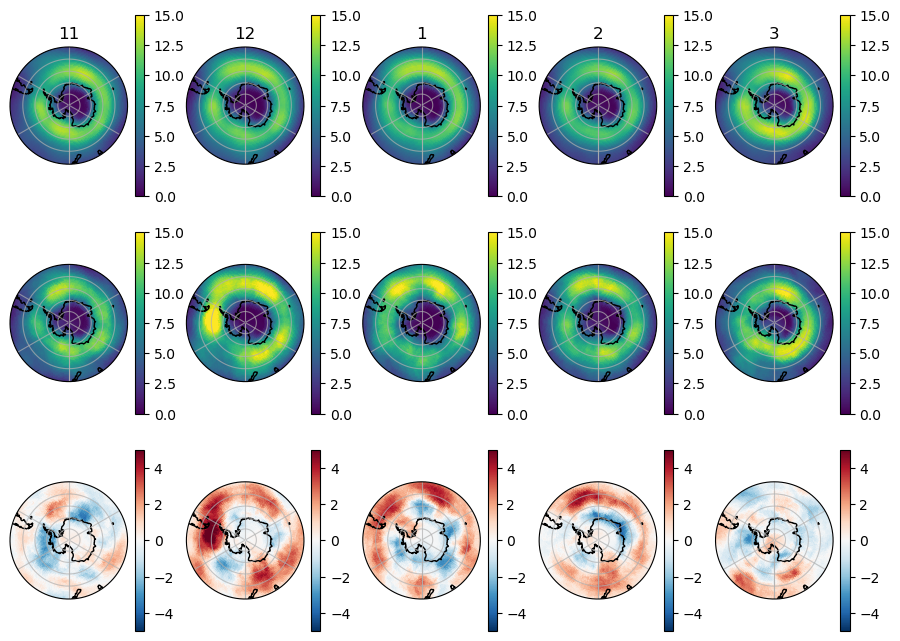

In [31]:
ds_mask = xr.open_mfdataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc',use_cftime=True)
mask_monthly = ds_mask.mask_monthly

#for summers where we have to skip over the years
idx_hi = (mask_monthly.time.dt.year.isin(high_years) & mask_monthly.time.dt.month.isin([7,8,9,10,11,12])) | (mask_monthly.time.dt.year.isin(high_years + 1) & mask_monthly.time.dt.month.isin([1,2,3,4,5,6]))
idx_low = (mask_monthly.time.dt.year.isin(low_years) & mask_monthly.time.dt.month.isin([7,8,9,10,11,12])) | (mask_monthly.time.dt.year.isin(low_years + 1) & mask_monthly.time.dt.month.isin([1,2,3,4,5,6]))

#idx_hi = mask_monthly.time.dt.year.isin(high_years)
#idx_low = mask_monthly.time.dt.year.isin(low_years)

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(11,8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

summ_months = np.arange(10,10+5) % 12 + 1
wint_months = np.arange(5,10)

for i, mon in enumerate(summ_months):
    idx_month = mask_monthly.time.dt.month == mon
    
    mask_monthly[idx_month,:,:].mean(dim='time').plot(ax=axs[0][i], x='lon', y='lat', 
                                                      vmin=0, vmax=15,
                                                      extend='neither',
                                                      transform=ccrs.PlateCarree(),
                                                      cbar_kwargs={'label':''})
    axs[0][i].set_title(mon)
    
    mask_monthly[idx_month & idx_hi,:,:].mean(dim='time').plot(ax=axs[1][i], x='lon', y='lat', 
                                                               transform=ccrs.PlateCarree(),
                                                               vmin=0, vmax=15,
                                                               extend='neither',
                                                               cbar_kwargs={'label':''})
    
    (mask_monthly[idx_month & idx_hi,:,:].mean(dim='time') - mask_monthly[idx_month,:,:].mean(dim='time')).plot(ax=axs[2][i], 
                                                                                                                x='lon', y='lat', 
                                                                                                                transform=ccrs.PlateCarree(),
                                                                                                                vmin=-5, vmax=5,
                                                                                                                extend='neither',
                                                                                                                cmap='RdBu_r',
                                                                                                                cbar_kwargs={'label':''})
    
    for j in range(3):
        axs[j][i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
        axs[j][i].gridlines(alpha=0.7)
        axs[j][i].set_boundary(circle, transform=axs[j][i].transAxes)
        axs[j][i].coastlines()
        
plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_activity_5mosummer_{mod}_high.png', 
            format='png', 
            dpi=100)

## Creating composites for variables based on the index used - DJF or JJA only

In [33]:
ds = xr.open_mfdataset(f'{fpath_nc[mod]}/{files[mod][var]}', use_cftime=True)
da = (c[var] * ds[var]).resample(time='QS-DEC').mean()[::4]

da_mu = da.mean(dim='time')
da_std = da.std(dim='time')

In [34]:
idx_lo = da.time.dt.year.isin(low_years)
idx_hi = da.time.dt.year.isin(high_years)

d_hi = da[idx_hi,:,:].mean(dim='time') - da.mean(dim='time')
d_lo = da[idx_lo,:,:].mean(dim='time') - da.mean(dim='time')

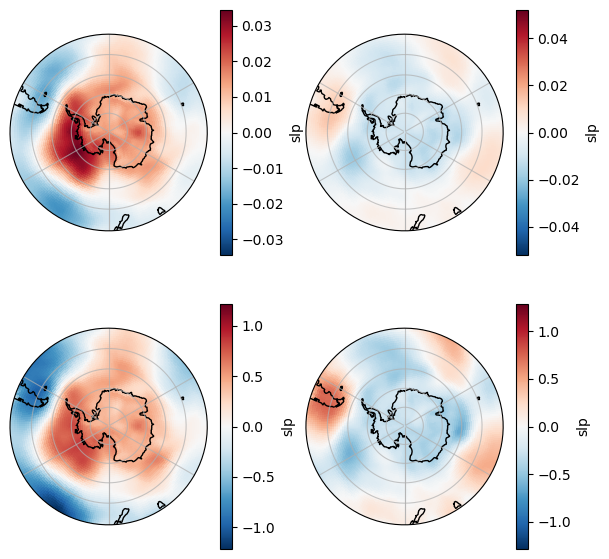

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          #vmax=.75, vmin=-.75, extend='neither',
          #cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          #vmax=.75, vmin=-.75, extend='neither',
          #cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi/da_std).plot(ax=axs[2], transform=ccrs.PlateCarree())

(d_lo/da_std).plot(ax=axs[3], transform=ccrs.PlateCarree())

#axs[0].set_title(f'Summer monthly $\sigma${var}')
#axs[1].set_title(f'$\Delta${var}, high storm years')
#axs[2].set_title(f'$\Delta${var}, low storm years')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormywint_toscomp.png', format='png', dpi=100)

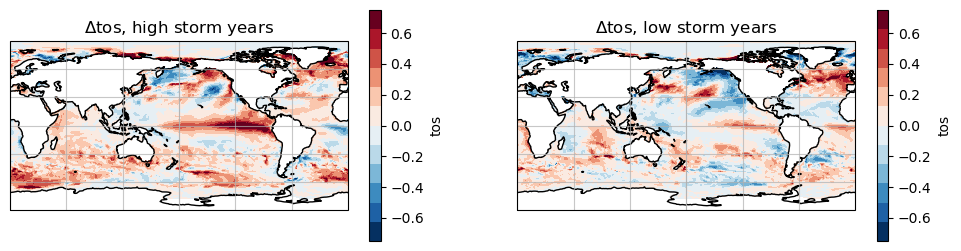

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                       figsize=(12,3))
axs=axs.flatten()

(c[var]*(ds[var][idx_hi,:,:].mean(dim='time') - ds[var][idx_jja,:,:].mean(dim='time'))).plot(ax=axs[0], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

(c[var]*(ds[var][idx_lo,:,:].mean(dim='time') - ds[var][idx_jja,:,:].mean(dim='time'))).plot(ax=axs[1], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

axs[0].set_title(f'$\Delta${var}, high storm years')
axs[1].set_title(f'$\Delta${var}, low storm years')

for i in range(2):
    axs[i].gridlines(alpha=0.7)
    axs[i].coastlines()
    
plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormywint_toscomp_global.png', format='png', dpi=100)

## Looking at 6-month anomalies for storms and conditions

In [67]:
idx2 = ds_idx.center_counts[3:-3].coarsen(time=6).sum()[1:-2:2]

low_years2 = idx2.sortby(idx2).time[:7].dt.year
high_years2 = idx2.sortby(idx).time[-7:].dt.year

In [68]:
ds = xr.open_mfdataset(f'{fpath_nc[mod]}/{files[mod][var]}', use_cftime=True)
da = (c[var] * ds[var][3:-3,:,:]).coarsen(time=6).mean()[1:-2:2]

da_mu = da.mean(dim='time')
da_std = da.std(dim='time')

In [79]:
idx_lo = da.time.dt.year.isin(low_years2)
idx_hi = da.time.dt.year.isin(high_years2)

d_hi = da[idx_hi,:,:].mean(dim='time') - da.mean(dim='time')
d_lo = da[idx_lo,:,:].mean(dim='time') - da.mean(dim='time')

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


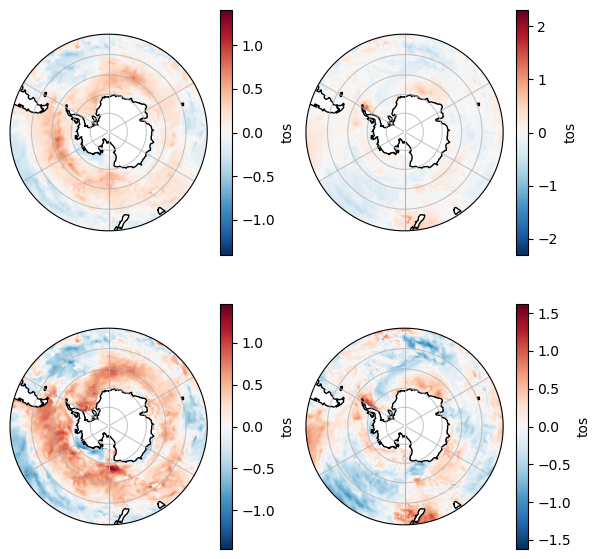

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          #vmax=.75, vmin=-.75, extend='neither',
          #cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          #vmax=.75, vmin=-.75, extend='neither',
          #cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi/da_std).plot(ax=axs[2], transform=ccrs.PlateCarree())

(d_lo/da_std).plot(ax=axs[3], transform=ccrs.PlateCarree())

#axs[0].set_title(f'Summer monthly $\sigma${var}')
#axs[1].set_title(f'$\Delta${var}, high storm years')
#axs[2].set_title(f'$\Delta${var}, low storm years')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormywint_toscomp.png', format='png', dpi=100)

## Summer stormy and non-stormy years

In [53]:
high_years = {'CM4':np.array([182, 184, 197, 203, 220, 229, 230]),
              'ESM4':np.array([10, 26, 54, 60, 62, 73, 90])}
low_years = {'CM4':np.array([161, 172, 177, 213, 215, 232, 237]),
             'ESM4':np.array([46, 51, 52, 56, 64, 93, 97])}

hy = high_years[mod]
ly = low_years[mod]

In [54]:
summer_months_p1 = [12]
summer_months_p2 = [1,2]

idx_hi = (ds.time.dt.year.isin(hy-1) & ds.time.dt.month.isin(summer_months_p1)) | (ds.time.dt.year.isin(hy) & ds.time.dt.month.isin(summer_months_p2)) 
idx_lo = (ds.time.dt.year.isin(ly-1) & ds.time.dt.month.isin(summer_months_p1)) | (ds.time.dt.year.isin(ly) & ds.time.dt.month.isin(summer_months_p2))

idx_djf = ds.time.dt.season == 'DJF'

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


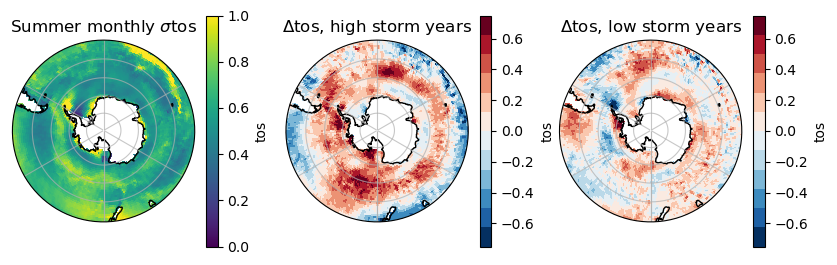

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(10,3))
axs=axs.flatten()

(c[var]*ds_monthly[var][::4,:,:]).std(dim='time').plot(ax=axs[0], transform=ccrs.PlateCarree(), 
                                                        vmin=0, vmax=1, extend='neither'
                                                       )


(c[var]*(ds[var][idx_hi,:,:].mean(dim='time') - ds[var][idx_djf,:,:].mean(dim='time'))).plot(ax=axs[1], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

(c[var]*(ds[var][idx_lo,:,:].mean(dim='time') - ds[var][idx_djf,:,:].mean(dim='time'))).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

axs[0].set_title(f'Summer monthly $\sigma${var}')
axs[1].set_title(f'$\Delta${var}, high storm years')
axs[2].set_title(f'$\Delta${var}, low storm years')

for i in range(3):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormysumm_toscomp.png', format='png', dpi=100)

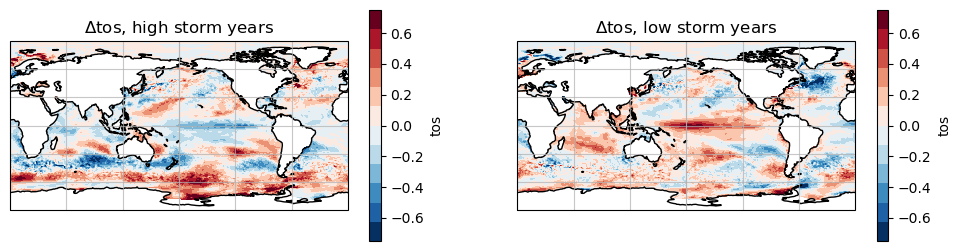

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                       figsize=(12,3))
axs=axs.flatten()

(c[var]*(ds[var][idx_hi,:,:].mean(dim='time') - ds[var][idx_djf,:,:].mean(dim='time'))).plot(ax=axs[0], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

(c[var]*(ds[var][idx_lo,:,:].mean(dim='time') - ds[var][idx_djf,:,:].mean(dim='time'))).plot(ax=axs[1], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

axs[0].set_title(f'$\Delta${var}, high storm years')
axs[1].set_title(f'$\Delta${var}, low storm years')

for i in range(2):
    axs[i].gridlines(alpha=0.7)
    axs[i].coastlines()
    
plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormysumm_toscomp_global.png', format='png', dpi=100)

In [52]:
summer_storm_counts = xr.DataArray([4248, 4181, 4098, 4150, 4446, 4364, 4399, 4104, 4509, 4224, 4063,
                       4303, 4587, 4110, 4209, 4272, 4219, 4422, 4455, 4272, 4055, 4228,
                       4466, 4410, 4404, 4327, 4211, 4226, 4169, 4580, 4286, 4349, 4477,
                       4691, 4554, 4456, 4440, 4225, 4292, 3974, 4532, 4164, 4448, 4285,
                       4313, 4567, 4388, 4355, 4234, 4452, 4083, 4284, 4723, 4193, 4536,
                       4245, 4231, 4456, 4259, 4050, 4405, 4114, 3952, 4402, 4116, 4382,
                       4176, 4323, 4776, 4318, 4463, 4084, 4382, 4134, 4179, 4039, 4391,
                       4466, 4614, 4442, 4262, 4012, 4171, 4412, 4460, 4047, 3884, 4256,
                       4550, 4291, 4503, 4218, 4511, 4448, 4332],
                                   dims=("time"),
                                   coords=[
                                       ("time", ds_monthly.time[:-1:4].data)
                                   ]
                                  )

winter_storm_counts = xr.DataArray([4556, 4664, 4831, 4930, 4624, 4806, 4848, 5014, 5199, 4835, 4804,
       4862, 5115, 4859, 4866, 4722, 4584, 4740, 4731, 4886, 4800, 4631,
       4536, 4910, 4472, 4677, 4890, 4771, 4781, 4908, 4836, 5142, 4648,
       4842, 4773, 4928, 4527, 4806, 4921, 4899, 5044, 5012, 4821, 5143,
       4737, 4672, 4627, 5421, 4798, 4719, 4830, 4979, 4912, 4899, 4490,
       4787, 4645, 4840, 4781, 4939, 4993, 4900, 4630, 4587, 4701, 4923,
       4786, 4574, 5122, 4502, 4452, 4816, 4811, 4983, 4946, 4801, 4923,
       4548, 5187, 4631, 4905, 4479, 4850, 4694, 4904, 4751, 5163, 4482,
       4948, 4983, 4896, 5089, 5025, 4570, 4408],
                                   dims=("time"),
                                   coords=[
                                       ("time", ds_monthly.time[2:-1:4].data)
                                   ]
                                  )

In [53]:
test = xr.corr(winter_storm_counts, ds_monthly.slp[2:-1:4,:,:], dim="time")

In [55]:
n = 95
r = test

# Compute t-statistic
t_stat = r * np.sqrt((n - 2) / (1 - r**2))

# Compute two-tailed p-value
pval = xr.apply_ufunc(
    lambda x: 2 * t.sf(np.abs(x), df=n - 2),
    t_stat,
    input_core_dims=[[]],
    output_core_dims=[[]],
    vectorize=True,
    dask="allowed"
)

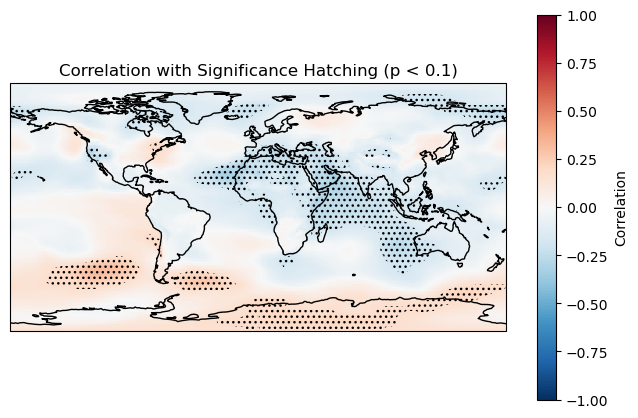

In [56]:
proj = ccrs.PlateCarree()  # or another if you're using rotated pole etc.

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': proj})

# Plot the correlation field
pc = ax.pcolormesh(
    r.lon, r.lat, r,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-1, vmax=1
)
fig.colorbar(pc, ax=ax, label='Correlation')

# Add hatching for non-significant areas
sig_mask = pval < 0.10

hatch = ax.contourf(
    r.lon, r.lat, sig_mask,
    levels=[0.5, 1],
    hatches=['...', None],
    colors='none',
    transform=ccrs.PlateCarree()
)

# Add coastlines and optional features
ax.coastlines()

ax.set_title("Correlation with Significance Hatching (p < 0.1)")

plt.show()

## Soft weighting approach (try to emphasize extreme storm years)

In [96]:
summer_anomaly = summer_storm_counts - summer_storm_counts.mean()

summer_weights = summer_anomaly**2 #np.abs(summer_anomaly)
summer_weights = summer_weights / summer_weights.sum()

In [97]:
a = summer_storm_counts 
b = ds_monthly.tos[:-1:4,:,:]

# Compute weighted means
mean_a = (a * summer_weights).sum(dim='time')
mean_b = (b * summer_weights).sum(dim='time')

In [98]:
# Compute weighted covariance and variances
cov_ab = ((a - mean_a) * (b - mean_b) * summer_weights).sum(dim='time')
var_a = ((a - mean_a)**2 * summer_weights).sum(dim='time')
var_b = ((b - mean_b)**2 * summer_weights).sum(dim='time')

r_sqweighted = cov_ab / np.sqrt(var_a * var_b)

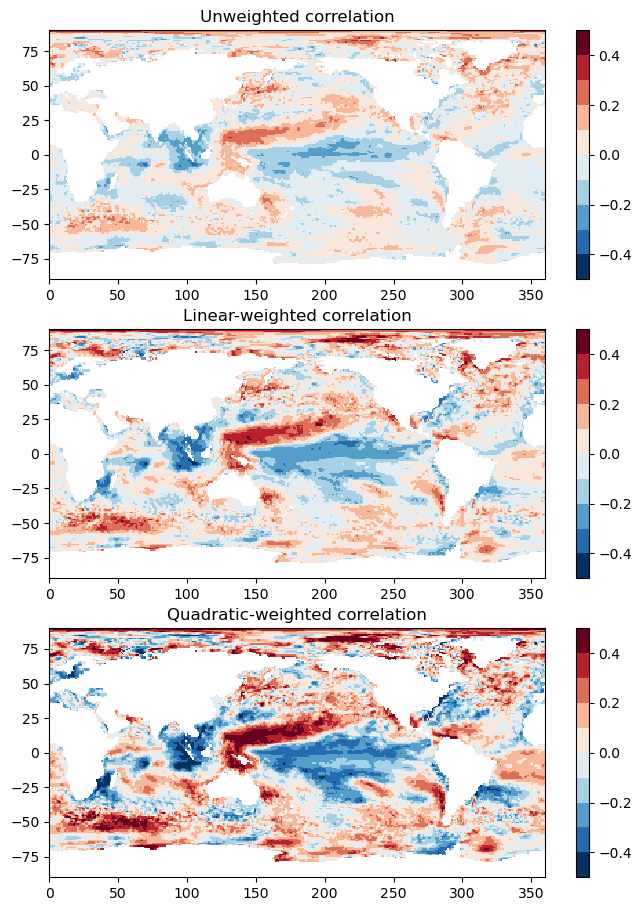

In [103]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,11))

r_unweighted.plot(ax=axs[0], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[0].set_title('Unweighted correlation')
r_weighted.plot(ax=axs[1], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[1].set_title('Linear-weighted correlation')
r_sqweighted.plot(ax=axs[2], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[2].set_title('Quadratic-weighted correlation')

for i in range(3):
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
plt.savefig('/home/Katherine.Turner/Figures/summer_storms_SST_corr_options.png', format='png', dpi=100)

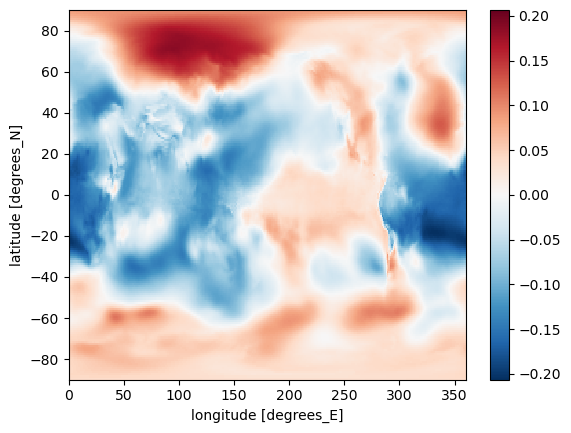

In [81]:
(r_weighted - r_unweighted).plot()